In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

## Data Input

In [366]:
df = pd.DataFrame() 
try:
    df = pd.read_csv('data.tsv', sep='\t', names=["URL", "Name", "Price", "Processor", "Storage", "RAM", "OperatingSystem", "ScreenSize", "Resolution", "Height", "Camera", "Colour"])
except FileNotFoundError:
    print("Error: File 'data.tsv' not found.")

df.shape

(150, 12)

In [367]:
df.head()

,URL,Name,Price,Processor,Storage,RAM,OperatingSystem,ScreenSize,Resolution,Height,Camera,Colour
0,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A9 8.7"" Graphite 64GB Wi-Fi...",£109.00,Helio G99,64GB,4GB,Android,8.7Inch,1340 x 800,13cm,8MP,Graphite
1,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab Active5 8"" Green 128GB Wi-F...",£399.00,Exynos 1380,128GB,6GB,Android,8Inch,1920 x 1200,13cm,13MP,Green
2,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab S10 FE 10.9"" Grey 256GB Wi-...",£399.00,Octa-Core,256GB,12GB,Android,10.9Inch,2304 x 1440pixels,17cm,13MP,Grey
3,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A7 Lite 8.7"" Grey 32GB Cell...",£129.97,MT8768T,32GB,3GB,Android,8.7Inch,1340 x 800,13cm,8MP,Grey
4,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A9 8.7"" Graphite 64GB 4G Ta...",£139.00,Helio G99,64GB,4GB,Android,8.7Inch,1340 x 800,13cm,8MP,Graphite


## 1 Explorative Analysis

In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   URL              150 non-null    object
 1   Name             150 non-null    object
 2   Price            149 non-null    object
 3   Processor        147 non-null    object
 4   Storage          149 non-null    object
 5   RAM              147 non-null    object
 6   OperatingSystem  144 non-null    object
 7   ScreenSize       150 non-null    object
 8   Resolution       150 non-null    object
 9   Height           150 non-null    object
 10  Camera           127 non-null    object
 11  Colour           149 non-null    object
dtypes: object(12)
memory usage: 14.2+ KB


In [369]:
df.isna().sum()

URL                 0
Name                0
Price               1
Processor           3
Storage             1
RAM                 3
OperatingSystem     6
ScreenSize          0
Resolution          0
Height              0
Camera             23
Colour              1
dtype: int64

### 1.1 Converting types

In [370]:
df['Price'] = df['Price'].str.replace('£', '').str.replace(',', '').replace('N/A', np.nan).astype(float)
df['RAM'] = df['RAM'].str.replace('GB', '').replace('N/A', np.nan).astype(float)
df['Storage'] = pd.to_numeric(df['Storage'].str.replace(r'[^\d.]', '', regex=True), errors='coerce') * np.where(df['Storage'].str.contains('TB', na=False), 1024, 1)
df['ScreenSize'] = df['ScreenSize'].str.replace('Inch', '').str.replace('es', '').str.replace('in', '').replace('N/A', np.nan).astype(float)
df['Camera'] = pd.to_numeric(df['Camera'].str.replace(r'[^\d.]', '', regex=True), errors='coerce')
df['Height'] = pd.to_numeric(df['Height'].str.replace(r'[^\d.]', '', regex=True), errors='coerce')
df['Resolution'] = df['Resolution'].str.replace('pixels', '').replace('N/A', np.nan)
def get_res(val):
    nums = re.findall(r'(\d+)', str(val))
    return int(nums[0]) * int(nums[1]) if len(nums) >= 2 else np.nan

df['Brand'] = df['Name'].apply(lambda x: x.split()[0])
df['Resolution_Total'] = df['Resolution'].apply(get_res)
df.head()

,URL,Name,Price,Processor,Storage,RAM,OperatingSystem,ScreenSize,Resolution,Height,Camera,Colour,Brand,Resolution_Total
0,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A9 8.7"" Graphite 64GB Wi-Fi...",109.00,Helio G99,64.0,4.0,Android,8.7,1340 x 800,13,8.0,Graphite,Samsung,1072000
1,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab Active5 8"" Green 128GB Wi-F...",399.00,Exynos 1380,128.0,6.0,Android,8.0,1920 x 1200,13,13.0,Green,Samsung,2304000
2,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab S10 FE 10.9"" Grey 256GB Wi-...",399.00,Octa-Core,256.0,12.0,Android,10.9,2304 x 1440,17,13.0,Grey,Samsung,3317760
3,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A7 Lite 8.7"" Grey 32GB Cell...",129.97,MT8768T,32.0,3.0,Android,8.7,1340 x 800,13,8.0,Grey,Samsung,1072000
4,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A9 8.7"" Graphite 64GB 4G Ta...",139.00,Helio G99,64.0,4.0,Android,8.7,1340 x 800,13,8.0,Graphite,Samsung,1072000


In [371]:
df['OperatingSystem'].value_counts()

OperatingSystem
Android       55
iPadOS 18     51
iPadOS        31
Android 13     2
Android 14     1
Android 15     1
iOS            1
iPadOS 16      1
Windows        1
Name: count, dtype: int64

In [372]:
df['Brand'].value_counts()

Brand
Apple          70
Samsung        41
Refurbished    24
Lenovo          6
TCL             4
Acer            3
Alcatel         1
Microsoft       1
Name: count, dtype: int64

In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   URL               150 non-null    object 
 1   Name              150 non-null    object 
 2   Price             149 non-null    float64
 3   Processor         147 non-null    object 
 4   Storage           149 non-null    float64
 5   RAM               147 non-null    float64
 6   OperatingSystem   144 non-null    object 
 7   ScreenSize        150 non-null    float64
 8   Resolution        150 non-null    object 
 9   Height            150 non-null    int64  
 10  Camera            127 non-null    float64
 11  Colour            149 non-null    object 
 12  Brand             150 non-null    object 
 13  Resolution_Total  150 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 16.5+ KB


In [374]:
df.describe().round(2)

,Price,Storage,RAM,ScreenSize,Height,Camera,Resolution_Total
count,149.00,149.00,147.00,150.00,150.00,127.00,150.00
mean,649.22,286.93,7.51,11.41,19.64,11.11,3966362.45
std,381.57,326.24,3.53,1.54,8.72,2.26,1300055.43
min,54.97,32.00,1.00,7.00,1.00,2.00,614400.00
25%,404.97,128.00,4.00,10.90,17.00,12.00,3371808.00
50%,599.00,256.00,8.00,11.00,25.00,12.00,3870400.00
75%,854.97,256.00,8.00,13.00,25.00,12.00,5184000.00
max,2124.97,2048.00,16.00,14.60,29.00,13.00,5680128.00


In [375]:
result = df.select_dtypes(include=['number']).agg(['mean', 'median', lambda x: x.mode().iat[0]], axis=0)
result.index = ['mean', 'median', 'modus']
result.round(2)

,Price,Storage,RAM,ScreenSize,Height,Camera,Resolution_Total
mean,649.22,286.93,7.51,11.41,19.64,11.11,3966362.45
median,599.00,256.00,8.00,11.00,25.00,12.00,3870400.00
modus,564.97,256.00,8.00,11.00,25.00,12.00,3870400.00


### 1.2 Data Distribution

Text(0.5, 1.0, 'Distribution of Tablet Prices')

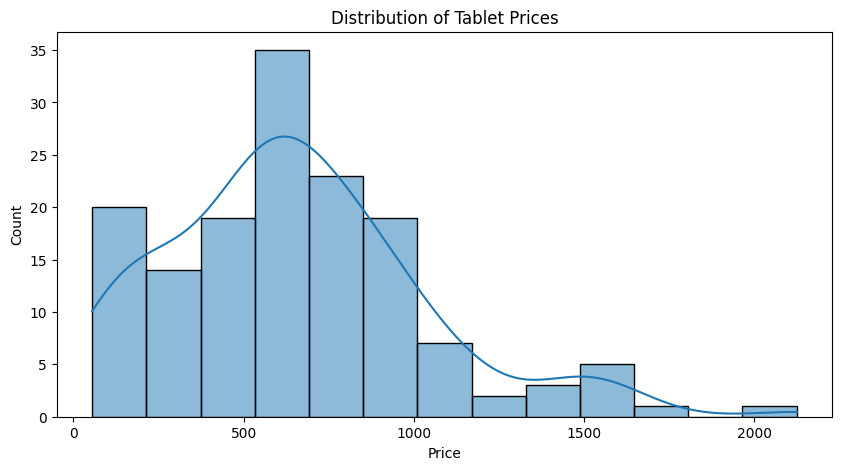

In [376]:
# Distribution of Price (Histogram)
plt.figure(figsize=(10, 5))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Tablet Prices')
# COMMENT: The distribution is right-skewed, showing a concentration of budget tablets with a long tail of luxury models.

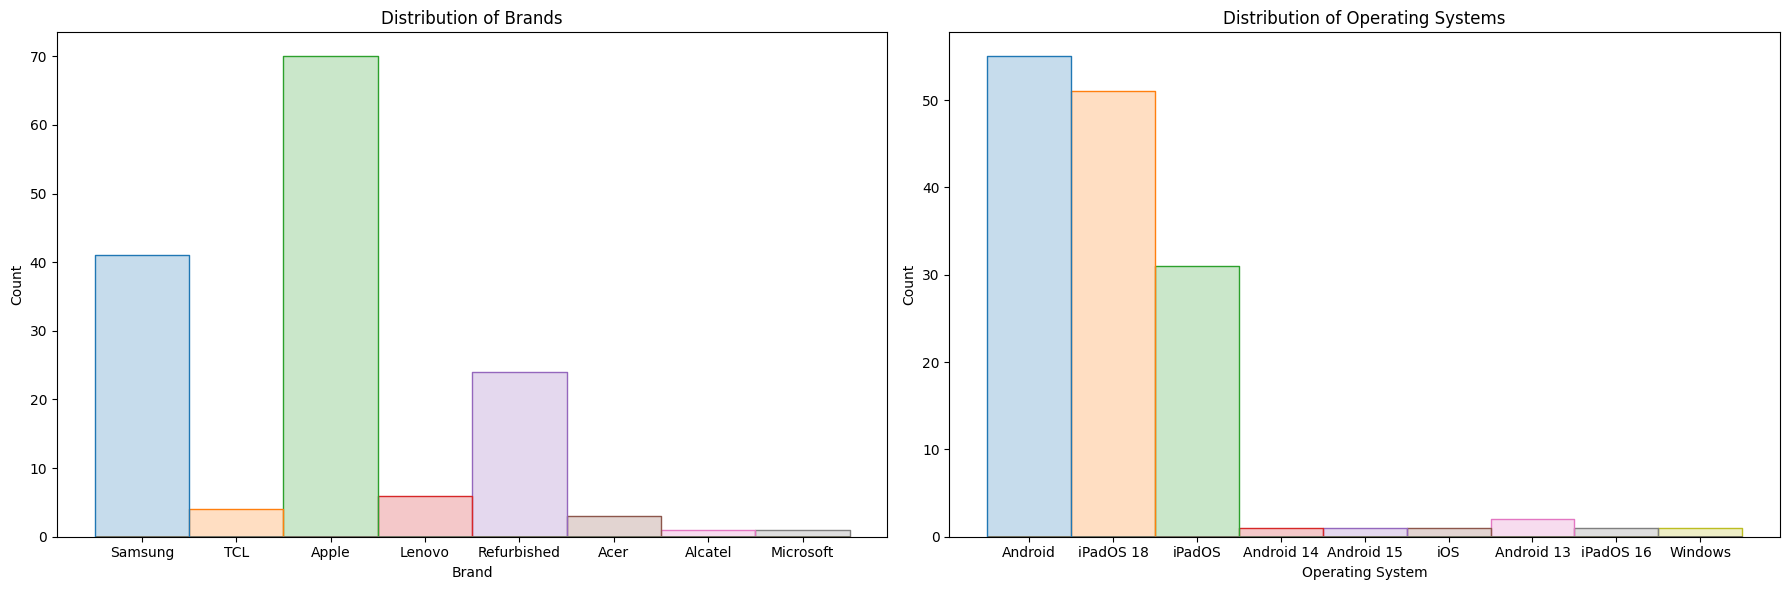

In [377]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=df, x='Brand', hue='Brand', element="step", ax=axes[0], legend=False)
axes[0].set_title('Distribution of Brands')
axes[0].set_xlabel('Brand')

sns.histplot(data=df, x='OperatingSystem', hue='OperatingSystem', element="step", ax=axes[1], legend=False)
axes[1].set_title('Distribution of Operating Systems')
axes[1].set_xlabel('Operating System')

plt.tight_layout()

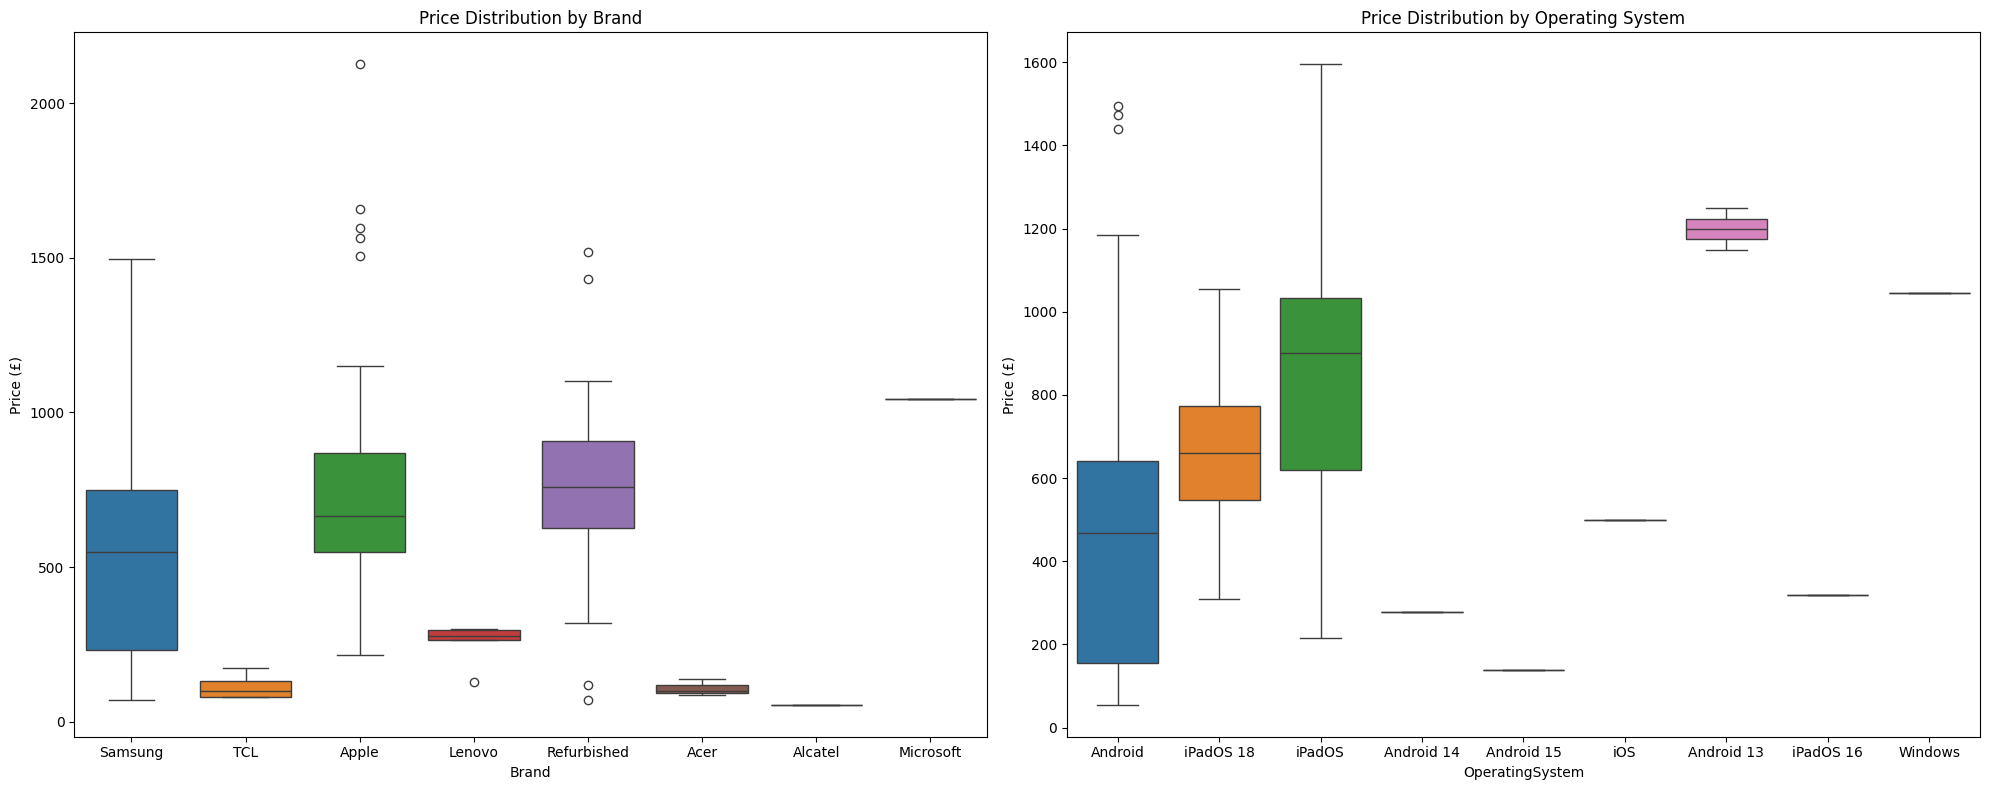

In [378]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.boxplot(data=df, x='Brand', y='Price', hue='Brand', ax=axes[0])
axes[0].set_title('Price Distribution by Brand')
axes[0].set_ylabel('Price (£)')
axes[0].tick_params(axis='x')

sns.boxplot(data=df, x='OperatingSystem', y='Price', hue='OperatingSystem', ax=axes[1])
axes[1].set_title('Price Distribution by Operating System')
axes[1].set_ylabel('Price (£)')
axes[1].legend_.remove()

plt.tight_layout()

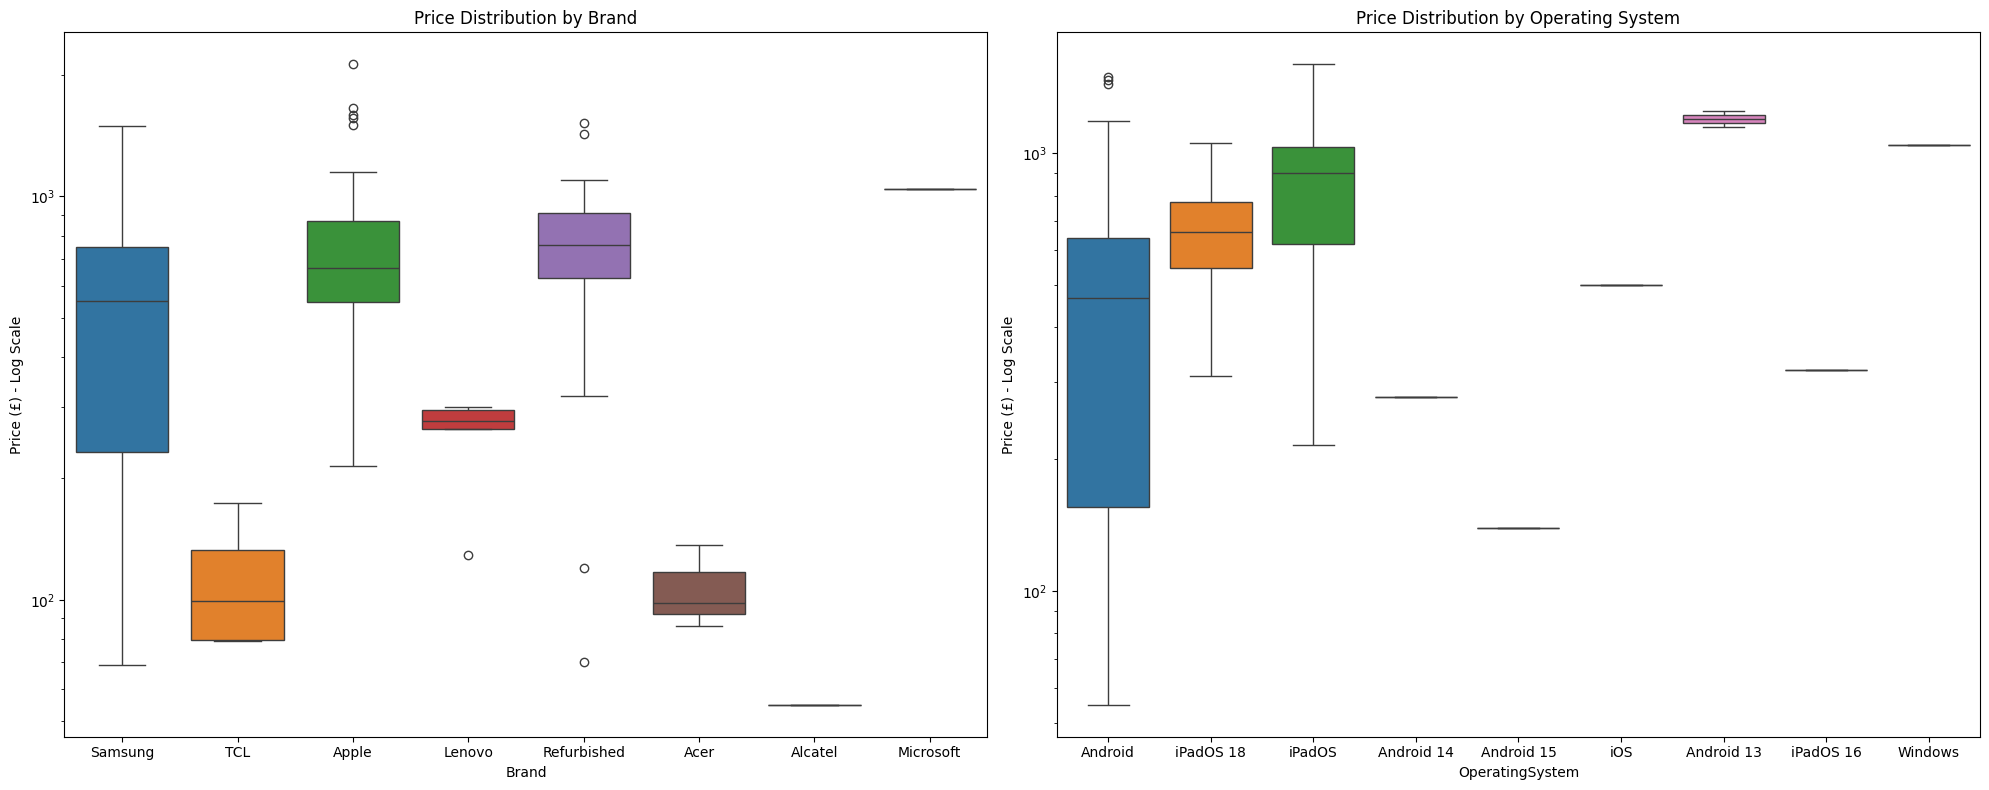

In [379]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.boxplot(data=df, x='Brand', y='Price', hue='Brand', ax=axes[0])
axes[0].set_yscale('log')  
axes[0].set_title('Price Distribution by Brand')
axes[0].set_ylabel('Price (£) - Log Scale')
axes[0].tick_params(axis='x')

sns.boxplot(data=df, x='OperatingSystem', y='Price', hue='OperatingSystem', ax=axes[1])
axes[1].set_yscale('log') 
axes[1].set_title('Price Distribution by Operating System')
axes[1].set_ylabel('Price (£) - Log Scale')
if axes[1].legend_:
    axes[1].legend_.remove()

plt.tight_layout()

Text(0.5, 1.0, 'RAM Capacity vs. Price')

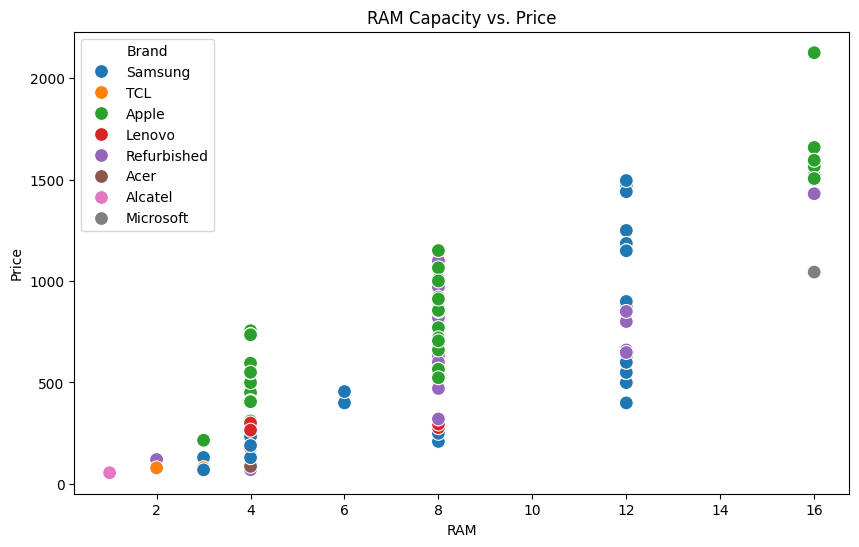

In [380]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='RAM', y='Price', hue='Brand', s=100)
plt.title('RAM Capacity vs. Price')

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 8))

axes = axes.flatten()

sns.violinplot(data=df, x='ScreenSize', y='Price', hue='ScreenSize', 
               palette='viridis', ax=axes[0], legend=False)
axes[0].set_title('Price Distribution by Screen Sizes')
axes[0].set_xlabel('Screen Size (Inches)')
axes[0].set_ylabel('Price (£)')

sns.violinplot(data=df, x='Storage', y='Price', hue='Storage', 
               palette='viridis', ax=axes[1], legend=False)
axes[1].set_title('Price Distribution by Storage Tier')
axes[1].set_xlabel('Storage (GB)')
axes[1].set_ylabel('Price (£)')

sns.violinplot(data=df, x='RAM', y='Price', hue='RAM', 
               palette='viridis', ax=axes[2], legend=False)
axes[2].set_title('Price Distribution by RAM Capacity')
axes[2].set_xlabel('RAM (GB)')
axes[2].set_ylabel('Price (£)')

sns.violinplot(data=df, x='Camera', y='Price', hue='Camera', 
               palette='viridis', ax=axes[3], legend=False)
axes[3].set_title('Price Distribution by Camera')
axes[3].set_xlabel('Camera')
axes[3].set_ylabel('Price (£)')

sns.violinplot(data=df, x='OperatingSystem', y='Price', hue='OperatingSystem', 
               palette='viridis', ax=axes[4], legend=False) 
axes[4].set_title('Price Distribution by Operating System')
axes[4].set_xlabel('Operating System')
axes[4].set_ylabel('Price (£)')

sns.violinplot(data=df, x='Camera', y='Price', hue='Camera',
                palette='viridis', ax=axes[5], legend=False)
axes[5].set_title('Price Distribution by Camera')
axes[5].set_xlabel('Total Resolution (Pixels)')
axes[5].set_ylabel('Price (£)')

for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

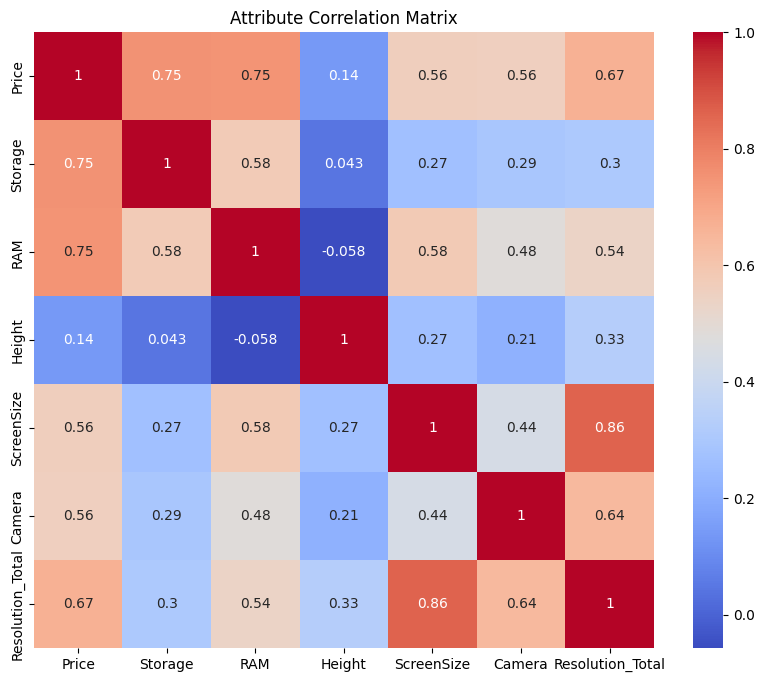

In [ ]:
plt.figure(figsize=(10, 8))
correlation_cols = ['Price', 'Storage', 'RAM', 'Height', 'ScreenSize', 'Camera', 'Resolution_Total']
sns.heatmap(df[correlation_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Attribute Correlation Matrix')
plt.show()

### 1.3 Outlier Detection

In [ ]:
def outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)
    
    return outliers

outliers_price   = outliers_iqr(df, 'Price')
outliers_storage = outliers_iqr(df, 'Storage')
outliers_ram     = outliers_iqr(df, 'RAM')
outliers_screen  = outliers_iqr(df, 'ScreenSize')
outliers_height  = outliers_iqr(df, 'Height')

In [ ]:
df[outliers_ram][['Name', 'RAM']]

,Name,RAM
87,"Refurbished Apple iPad Pro 2024 13"" Space Blac...",16.0
92,"Refurbished Apple iPad Pro 2024 13"" Space Blac...",16.0
138,"Apple iPad Pro 2021 11"" Silver 2TB Wi-Fi Tablet",16.0
139,"Apple iPad Pro 2021 12.9"" Space Grey 2TB Wi-Fi...",16.0
145,Microsoft Surface Pro 11 Snapdragon X Plus 16G...,16.0
147,"Apple iPad Pro 2024 11"" Space Black 1TB Wi-Fi ...",16.0
148,"Apple iPad Pro 2024 11"" Standard Glass Silver ...",16.0
149,"Apple iPad Pro 2024 11"" Silver 1TB Wi-Fi Tablet",16.0


In [ ]:
df[outliers_storage][['Name', 'Storage']]

,Name,Storage
45,"Apple iPad Air 2024 13"" Blue 512GB Wi-Fi Tablet",512.0
51,"Samsung Galaxy Tab S9+ 12.4"" Graphite 512GB 5G...",512.0
58,"Apple iPad Air 2025 11"" Blue 512GB Wi-Fi Tablet",512.0
65,"Apple iPad 2025 11"" Silver 512GB Wi-Fi Tablet",512.0
66,"Refurbished Apple iPad Pro 2024 11"" Black 512G...",512.0
67,"Refurbished Apple iPad Pro 2024 11"" Black 512G...",512.0
87,"Refurbished Apple iPad Pro 2024 13"" Space Blac...",1024.0
92,"Refurbished Apple iPad Pro 2024 13"" Space Blac...",2048.0
93,"Refurbished Apple iPad Pro 2024 13"" Black 512G...",512.0
96,"Refurbished Samsung Galaxy Tab S10 Ultra 14.6""...",512.0


In [ ]:
df[outliers_price][['Name', 'Price']]

,Name,Price
138,"Apple iPad Pro 2021 11"" Silver 2TB Wi-Fi Tablet",1657.97
139,"Apple iPad Pro 2021 12.9"" Space Grey 2TB Wi-Fi...",2124.97
147,"Apple iPad Pro 2024 11"" Space Black 1TB Wi-Fi ...",1564.97
149,"Apple iPad Pro 2024 11"" Silver 1TB Wi-Fi Tablet",1594.97


## 2 Preparation

### 2.1 Variant 1

In [ ]:
df1 = df.drop(columns=['URL', 'Name', 'Resolution', 'Height', 'Camera', 'Processor', 'Colour', 'Resolution_Total', 'ScreenSize'])
df1.isna().sum()

Price              1
Storage            1
RAM                3
OperatingSystem    6
Brand              0
dtype: int64

In [ ]:
df1['Price'] = df1['Price'].fillna(df1['Price'].mode()[0])
df1['Storage'] = df1['Storage'].fillna(df1['Storage'].mode()[0])
df1['RAM'] = df1['RAM'].fillna(df1['RAM'].mode()[0])
df1['OperatingSystem'] = df1['OperatingSystem'].fillna('Unknown')
df1.isna().sum()

Price              0
Storage            0
RAM                0
OperatingSystem    0
Brand              0
dtype: int64

### Discretization

In [ ]:
df1['Price_Tier'] = pd.cut(df1['Price'], bins=[0, 300, 700, 5000], labels=['Budget', 'MidRange', 'Premium'])
df1= df1.drop(columns=['Price']).head(50)
df1.head(50).to_csv('variant1.csv', index=False)
df1.head()

,Storage,RAM,OperatingSystem,Brand,Price_Tier
0,64.0,4.0,Android,Samsung,Budget
1,128.0,6.0,Android,Samsung,MidRange
2,256.0,12.0,Android,Samsung,MidRange
3,32.0,3.0,Android,Samsung,Budget
4,64.0,4.0,Android,Samsung,Budget


### 2.2 Variant 2

In [ ]:
df2 = df.drop(columns=['URL', 'Name', 'Resolution', 'Height', 'Camera', 'Processor', 'Price', 'RAM', 'Storage', 'ScreenSize', 'Resolution_Total'])
df2.isna().sum()

OperatingSystem    6
Colour             1
Brand              0
dtype: int64

In [ ]:
df2 = df2.dropna()
df2.isna().sum()

OperatingSystem    0
Colour             0
Brand              0
dtype: int64

In [ ]:
df2['OperatingSystem'].value_counts()

OperatingSystem
Android       55
iPadOS 18     51
iPadOS        31
Android 13     2
Android 14     1
Android 15     1
iOS            1
Windows        1
Name: count, dtype: int64

In [ ]:
print('Before: ' + str(df2['OperatingSystem'].nunique()))
df2.loc[df2['OperatingSystem'].str.contains('Android', case=False, na=False), 'OperatingSystem'] = 'Android'
df2.loc[df2['OperatingSystem'].str.contains('iOS|iPad', case=False, na=False), 'OperatingSystem'] = 'iOS'
df2.loc[df2['OperatingSystem'].str.contains('Windows', case=False, na=False), 'OperatingSystem'] = 'Windows'

print('After: ' + str(df2['OperatingSystem'].nunique()))
df2['OperatingSystem'].value_counts()

Before: 8
After: 3


OperatingSystem
iOS        83
Android    59
Windows     1
Name: count, dtype: int64

In [ ]:
print(df2['Brand'].nunique())
df2['Brand'].value_counts()

8


Brand
Apple          68
Samsung        39
Refurbished    21
Lenovo          6
TCL             4
Acer            3
Alcatel         1
Microsoft       1
Name: count, dtype: int64

In [ ]:
print(df2['Colour'].nunique())
df2['Colour'].value_counts()

17


Colour
Grey               40
Silver             22
Blue               17
Pink                9
Black               9
Purple              9
Beige               9
Graphite            8
Yellow              5
Space black         4
Green               2
Platinum silver     2
Moonstone grey      2
Rose Gold           2
Champagne           1
Starlight           1
Navy                1
Name: count, dtype: int64

In [ ]:
df2.head()

,OperatingSystem,Colour,Brand
0,Android,Graphite,Samsung
1,Android,Green,Samsung
2,Android,Grey,Samsung
3,Android,Grey,Samsung
4,Android,Graphite,Samsung


In [ ]:
scaler = MinMaxScaler()
brands = df2['Brand'].unique().tolist()
colours = df2['Colour'].unique().tolist()
operating_systems = df2['OperatingSystem'].unique().tolist()
enc = preprocessing.OneHotEncoder(categories=[operating_systems, colours, brands])
enc.fit(df2)
df2_selection_one_hot_coded = enc.transform(df2).toarray()
df2_selection_one_hot_coded_df = pd.DataFrame(df2_selection_one_hot_coded)
df2_selection_one_hot_coded_df.head(50).to_csv('variant2.csv', index=False)

In [ ]:
df2.head()

,OperatingSystem,Colour,Brand
0,Android,Graphite,Samsung
1,Android,Green,Samsung
2,Android,Grey,Samsung
3,Android,Grey,Samsung
4,Android,Graphite,Samsung


In [ ]:
df2_selection_one_hot_coded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
